In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Packages 
import numpy as np
import xarray as xr
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import mpas_tools

from geometric_features import GeometricFeatures
from geometric_features import read_feature_collection

from mpas_tools.mesh.mask import compute_mpas_region_masks
from mpas_tools.parallel import create_pool
from mpas_tools.io import write_netcdf

import geojson
import json
import mosaic
import os.path
import mpasregions.sections as mps
import gsw
import warnings 
import glob
from xgcm import Grid

In [3]:
# global mesh
mesh_path = '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc'
mesh = xr.open_dataset(mesh_path)
mesh = mesh.assign_coords({
"VertexID": xr.DataArray(mesh.indexToVertexID, dims=('nVertices',)),
})

# global data
bmm_filepath = '/pscratch/sd/b/bmoorema/run_001_062/'
dso = xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-12-01.nc')

# open base mask that we will fill with 0s according to the original mask (this new mask will contain cells PLUS their corresponding edges and vertices)
# base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')


/tmp/ipykernel_1646690/4260513771.py:10: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  dso = xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-12-01.nc')


In [4]:
dso.xtime_startMonthly

months = ['01','02','03','04','05','06','07','08','09','10','11','12']
ds_list = []

prefix = '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStats'

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(0,12):
        month = months[i]
        file = prefix + f'Monthly.0063-{month}-01.nc'
        file_glob = glob.glob(file)
        ds = xr.open_dataset(bmm_filepath + file)[['xtime_startMonthly','timeMonthly_avg_normalVelocity','timeMonthly_avg_potentialDensity','timeMonthly_avg_layerThickness']]
        ds_xtime_startMonthly = ds.swap_dims({'Time':'xtime_startMonthly'})
        ds_list.append(ds_xtime_startMonthly)

dss = xr.concat(ds_list,dim='xtime_startMonthly')

```python
def extract_variables(ds):
    return ds[var_list]
xr.open_mfdataset(file = prefix + f'Monthly.0063-*-01.nc', preprocess=extract_variables)
```

In [5]:
# set up descriptor for plotting 
# # set up mesh to apply polypcolor
mesh.attrs['is_periodic'] = 'YES'
mesh.attrs['x_period'] = 360
mesh.attrs['y_period'] = 0.0

descriptor = mosaic.Descriptor(mesh,use_latlon=False)

### get edge and vertex indices for a transect created from an algorithm

In [6]:
LS_lats= np.array([54, 60, 66, 64, 58])   
LS_lons= np.array([302, 315, 310, 295, 296])

LS_lats = np.append(LS_lats, LS_lats[0])
LS_lons = np.append(LS_lons, LS_lons[0])

# # calculate transects from algorithm, sort vertices & edges to be in consecutive order
test_edges, test_verts = mps.calculate_transects_multiple_pts(LS_lons, LS_lats, mesh)

# from the transect, create a mask to capture the entire region specified by the transects
# this will also output lats and lons corresponding to test_verts
path = './'
filename = 'LS_test'
geojson_file_name = 'Labrador Sea from transect algorithm'
tags = "Labrador_Sea;Davis_Strait"
author = "Kaila Uyeda"

    
test_verts_lats, test_verts_lons, dsMasks = mps.transect_from_alg_create_nc(test_verts, 
                                                                            mesh, 
                                                                            path,
                                                                            filename, 
                                                                            geojson_file_name,
                                                                            tags, 
                                                                            author)

# use the dsMasks file to get the ACTUAL working vertices that you will need
# this eliminates duplicate vertices that would occur if the transect moves back on itself
# check that the vertices and edges from the mask are actually at the same plaaces...
# in other words, we have the correct cells for the mask but extra edges and vertices because of how the transect is created.
# we have to do this after we create a mask with the cells. Otherwise, we don't know what side of the boundary
# is considered "inside the mask"

alg_edges, alg_vertices = mps.find_and_sort_transect_edges_and_vertices(mesh,dsMasks)

LS_test_transect_from_alg.geojson exists!
Opening LS_test_transect_from_alg.nc as dsMasks


In [7]:
nEdges_along_boundary = xr.DataArray(np.arange(0, alg_edges.size), dims=("nEdges_along_boundary", ))
ds_boundary = xr.Dataset(coords={
    "nEdges_along_boundary": nEdges_along_boundary,
    "nEdges_ID": xr.DataArray(alg_edges, dims=("nEdges_along_boundary",))
})

In [8]:
ds_boundary

<xarray.Dataset> Size: 2kB
Dimensions:                (nEdges_along_boundary: 148)
Coordinates:
  * nEdges_along_boundary  (nEdges_along_boundary) int64 1kB 0 1 2 ... 146 147
    nEdges_ID              (nEdges_along_boundary) int32 592B 17579 ... 17579
Data variables:
    *empty*

In [9]:
nEdges_sorted = xr.DataArray(np.arange(0, alg_edges.size), dims=("nEdges_sorted", ))
sorted_boundary_ds = xr.Dataset(coords={
    "nEdges_sorted": nEdges_sorted,
    "xr_Edges_id": xr.DataArray(alg_edges, dims=("nEdges_sorted",))
})

In [10]:
sorted_boundary_ds

<xarray.Dataset> Size: 2kB
Dimensions:        (nEdges_sorted: 148)
Coordinates:
  * nEdges_sorted  (nEdges_sorted) int64 1kB 0 1 2 3 4 5 ... 143 144 145 146 147
    xr_Edges_id    (nEdges_sorted) int32 592B 17579 539876 ... 125371 17579
Data variables:
    *empty*

In [11]:
dss_cleaned = dss.isel(nEdges = sorted_boundary_ds.xr_Edges_id)

### get edge and vertex indices for a transect created from a mask

In [12]:
# open mask of desired region (this is to find transects from a pre-existing mask)

path = './'
filename = 'LS_test_transect_from_mask'

check_nc_existence = os.path.isfile(path + filename + '.nc')

# check if .nc mask file exists
if check_nc_existence == True:
    print(f'Opening {filename}.nc file as mask')
    mask = xr.open_dataset(path + filename + '.nc')
else: 
    print('Creating .nc file')
    check_geojson_existence = os.path.isfile(path + filename + '.geojson')

    # convert LS_test.geojson to LS_test.nc mask file
    if check_geojson_existence == True:
        print(f'Using {filename}.geojson to create .nc file')
        fcMask = read_feature_collection(path + filename + '.geojson')
        # pool = create_pool(process_count=8)
        dsMasks = compute_mpas_region_masks(mesh, fcMask, maskTypes =('cell',), pool=pool)
        dsMasks.to_netcdf(path + filename + '.nc', format='NETCDF4', mode='w')
        mask = xr.open_dataset(path + filename + '.nc')
        print(f'{filename}.nc created and opened as masks')
    else:
        print(f'{filename}.geojson does NOT exist!')

mask_edges, mask_vertices = mps.find_and_sort_transect_edges_and_vertices(mesh,mask)

Opening LS_test_transect_from_mask.nc file as mask


### Set up choice of edges and vertices based on method of creation.

In [13]:
method = 'alg' # 'mask'
if method == 'alg':
    edges, vertices = alg_edges, alg_vertices
    mask = dsMasks

if method == 'mask':
    edges, vertices = mask_edges, mask_vertices
    mask = mask

### A note on sign convention from normal velocity taken from [this python script on Github](https://github.com/milenaveneziani/analysis/blob/c7eb78deabb6fe9529d43fecdae6ce700eefff38/common_functions.py#L119) where 
`cellsOnEdge[nEdge,0]` is equivalent to my use of `A` cell, and \
`cellsonEdge[nEdge,1]` is equivalent to my use of `B` cell.

```ruby
# Compute edgeSigns so that transport INTO the region is positive. This is 
    # calculated considering that normalVelocity is positive when pointing from
    # cellsOnEdges[nEdge, 0] to cellsOnEdges[nEdge, 1]. Therefore, if 
    # cellsOnEdges[nEdge, 0] is outside the region and cellsOnEdges[nEdge, 1]
    # is inside the region, the sign remains unchanged (np.sign(regionMask[cellsOnEdges[nEdge, 1]] - 0.5)=1).
    # But, if cellsOnEdges[nEdge, 0] is inside the region and cellsOnEdges[nEdge, 1]
    # is outside the region, then the sign is flipped (np.sign(regionMask[cellsOnEdges[nEdge, 1]] - 0.5)
    # becomes -1. With this reasoning, the following also works (and we have verified that):
    # openBoundarySigns = -np.sign(regionMask[cellsOnEdges[~landEdges, 0]] - 0.5)
```

In [14]:
def calculate_velo_into_mask(ds, mesh, mask, outside_mask_values):
    ds['veloIntoMask'] = ds.timeMonthly_avg_normalVelocity * 0 
    
    # .isel the mesh to only get the sorted edges on the transect
    mesh_transect = mesh.isel(nEdges = dss_cleaned.nEdges_sorted.xr_Edges_id)
    
    # find transect edges on land
    xr_transect_edgesOnLand_TWO0 = mesh_transect.xr_Edges_id.where(np.isin(mesh_transect.cellsOnEdge.isel(TWO=0),0))
    xr_transect_edgesOnLand_TWO1 = mesh_transect.xr_Edges_id.where(np.isin(mesh_transect.cellsOnEdge.isel(TWO=1),0))
    xr_transect_edgesOnLand = np.union1d(xr_transect_edgesOnLand_TWO0, xr_transect_edgesOnLand_TWO1)
    
    # find transect edges on open ocean
    xr_transect_edgesOnOcean = np.setxor1d(edges, xr_transect_edgesOnLand)
    
    # select all the cells inside the mask
    xr_cells_inside, ignore_xr_inside_edges, ignore_xr_inside_vertices = mps.xr_inside_mask_info(mesh,mask)
    
    # of the open ocean edges, determine if the normal velocity is into or out of the mask
    
    # find the transect cells on open ocean edges
    n_transect_cellsOnOceanEdges = mesh_transect.cellsOnEdge
    xr_transect_cellsOnOceanEdges = mps.n_to_xr_idx(n_transect_cellsOnOceanEdges)
    
    # determine if the normal velocity points into or out of the mask
    for i in range(0,len(xr_transect_cellsOnOceanEdges)):
        for j in range(0,len(ds.xtime_startMonthly)):
            cellsOnSelectedEdge = xr_transect_cellsOnOceanEdges.isel(nEdges_sorted = i)
            selectedEdge = mesh_transect.nEdges_sorted.isel(nEdges_sorted = i)
            selectedMonth = ds.xtime_startMonthly.isel(xtime_startMonthly=j)
    
            if cellsOnSelectedEdge.isel(TWO=0).isin(xr_cells_inside): # if A is inside the mask
                ds.veloIntoMask.loc[dict(xtime_startMonthly = selectedMonth, nEdges_sorted = selectedEdge)] = ds.timeMonthly_avg_normalVelocity.loc[dict(xtime_startMonthly = selectedMonth, 
                                                                                                                                                         nEdges_sorted = selectedEdge)] * -1
    
            elif cellsOnSelectedEdge.isel(TWO=1).isin(xr_cells_inside): # if B is inside the mask
                ds.veloIntoMask.loc[dict(xtime_startMonthly = selectedMonth, nEdges_sorted = selectedEdge)] = ds.timeMonthly_avg_normalVelocity.loc[dict(xtime_startMonthly = selectedMonth, 
                                                                                                                                                         nEdges_sorted = selectedEdge)] * 1
    return ds, mesh_transect, xr_transect_cellsOnOceanEdges

In [15]:
ds = dss_cleaned
outside_mask_values = np.nan
ds_vIM, mesh_transect, xr_transect_cellsOnOceanEdges = calculate_velo_into_mask(ds, mesh,mask,outside_mask_values)

In [16]:
# calculate the area of the edge-layerThickness plane that the normal velocity moves through
# ------ INTERPOLATE LAYER THICKNESS ONTO NEDGES ------
# layerThickness sits on nCells, but veloIntoMask sits on nEdges
# we need to interpolate layerThickness onto nEdges by taking the average of the layerThickness of 2 cells that sit on the transect edge

# select only the layerThicknesses that are on cells that border the edges of the transect
cellsOnTransectEdge_layerThickness = ds_vIM.timeMonthly_avg_layerThickness.isel(nCells = xr_transect_cellsOnOceanEdges)

# take the mean of the layer thicknesses along the dimension "TWO" (take the mean of layer thickness between TWO=0 cell and TWO=1 cell)
interp_transectEdgeLayerThickness = cellsOnTransectEdge_layerThickness.mean(dim='TWO')

# ------ FIND THE WIDTH OF EACH TRANSECT EDGE ------
# find the dvEdge for all edges in transect
transectEdgeLength = mesh_transect.dvEdge

# ------ CALCULATE THE CROSS-SECTIONAL AREA OF THE TRANSECT BY MULTIPLYING THE LAYER THICKNESS BY THE EDGELENGTH ------
transect_area = interp_transectEdgeLayerThickness * transectEdgeLength

# ------ CALCLATE THE TRANSPORT INTO THE MASK ------
# multiply the cross-sectional area by teh veloIntoMask
transport = transect_area * ds_vIM.veloIntoMask

In [17]:
# create a new datavariable for transport, assign the transport to the corresponding edge
ds_vIM['transportIntoMask'] = transport

transportIntoMask_Sv = ds_vIM.transportIntoMask / 10**6

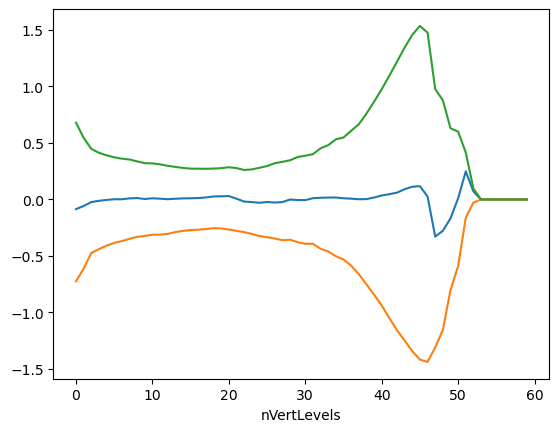

In [18]:
transport_neg = transport.where(transport < 0)
transport_pos = transport.where(transport > 0)

(transport.where(transport!=0).mean("xtime_startMonthly").sum("nEdges_sorted")*1e-6).plot()
(transport_neg.where(transport_neg!=0).mean("xtime_startMonthly").sum("nEdges_sorted")*1e-6).plot()
(transport_pos.where(transport_pos!=0).mean("xtime_startMonthly").sum("nEdges_sorted")*1e-6).plot()

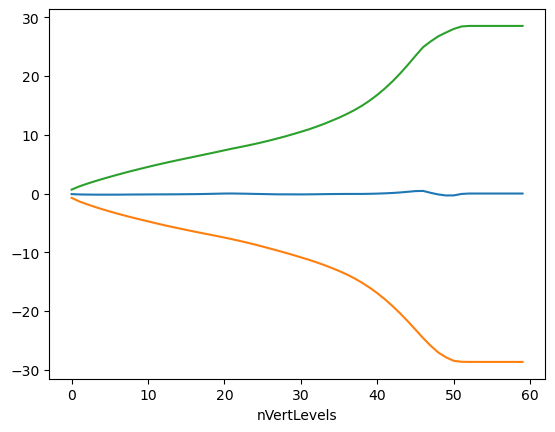

In [19]:
np.cumsum(transport.where(transport!=0).mean("xtime_startMonthly").sum("nEdges_sorted")*1e-6).plot()
np.cumsum(transport_neg.where(transport_neg!=0).mean("xtime_startMonthly").sum("nEdges_sorted")*1e-6).plot()
np.cumsum(transport_pos.where(transport_pos!=0).mean("xtime_startMonthly").sum("nEdges_sorted")*1e-6).plot()

In [20]:
# now, we want to attach the potential density to the transport so we can bin transport by potential density class
cellsOnTransectEdge_sigma = ds_vIM.timeMonthly_avg_potentialDensity.isel(nCells = xr_transect_cellsOnOceanEdges)

# take the mean of the potential density along the dimension "TWO" (take the mean of sigma between TWO=0 cell and TWO=1 cell)
interp_transectEdgeSigma = cellsOnTransectEdge_sigma.mean(dim='TWO')

# reassign the interpolated sigma datavariable that now sit on the cell edge instead of cell center
ds_vIM['edgeSigma'] = interp_transectEdgeSigma

edgeSigma_mask = ds_vIM.edgeSigma

In [21]:
edgeSigma_nadw = edgeSigma_mask > 1027.7
np.count_nonzero(edgeSigma_nadw.astype(int)==1)

nadw_transportMask_attempt = ds_vIM.transportIntoMask.where(edgeSigma_nadw ==True)

full_column_transport = transportIntoMask_Sv.sum(dim=['nVertLevels','nEdges_sorted']) 
nadw_column_transport = nadw_transportMask_attempt.sum(dim=['nVertLevels','nEdges_sorted']) / 10**6

display(full_column_transport.mean())
display(nadw_column_transport.mean())

<xarray.DataArray 'transportIntoMask' ()> Size: 8B
array(0.01035247)

<xarray.DataArray 'transportIntoMask' ()> Size: 8B
array(0.13111198)

In [22]:
np.arange(999,1028,0.25)

array([ 999.  ,  999.25,  999.5 ,  999.75, 1000.  , 1000.25, 1000.5 ,
       1000.75, 1001.  , 1001.25, 1001.5 , 1001.75, 1002.  , 1002.25,
       1002.5 , 1002.75, 1003.  , 1003.25, 1003.5 , 1003.75, 1004.  ,
       1004.25, 1004.5 , 1004.75, 1005.  , 1005.25, 1005.5 , 1005.75,
       1006.  , 1006.25, 1006.5 , 1006.75, 1007.  , 1007.25, 1007.5 ,
       1007.75, 1008.  , 1008.25, 1008.5 , 1008.75, 1009.  , 1009.25,
       1009.5 , 1009.75, 1010.  , 1010.25, 1010.5 , 1010.75, 1011.  ,
       1011.25, 1011.5 , 1011.75, 1012.  , 1012.25, 1012.5 , 1012.75,
       1013.  , 1013.25, 1013.5 , 1013.75, 1014.  , 1014.25, 1014.5 ,
       1014.75, 1015.  , 1015.25, 1015.5 , 1015.75, 1016.  , 1016.25,
       1016.5 , 1016.75, 1017.  , 1017.25, 1017.5 , 1017.75, 1018.  ,
       1018.25, 1018.5 , 1018.75, 1019.  , 1019.25, 1019.5 , 1019.75,
       1020.  , 1020.25, 1020.5 , 1020.75, 1021.  , 1021.25, 1021.5 ,
       1021.75, 1022.  , 1022.25, 1022.5 , 1022.75, 1023.  , 1023.25,
       1023.5 , 1023

In [23]:
# create vertical xgcm grid
grid = Grid(ds_vIM, coords = {'Z':{'center':'nVertLevels'}},periodic=False,autoparse_metadata=False)

# define target values in density
# edgeSigma_target = np.linspace(1023,1028,100)
edgeSigma_target = np.arange(999,1028,0.25)

# transform from nVertLevels to edgeSigma for the vertical coordinate
transport_transformed = grid.transform(ds_vIM.transportIntoMask, 'Z', edgeSigma_target, target_data = ds_vIM.edgeSigma)
mean_transport = transport_transformed.sum('nEdges_sorted').mean(dim='xtime_startMonthly') / 10**6
mean_transport_reversed  = mean_transport[::-1] # reverse order of transport into mask (surface transport now at bottom)
cs_mean_transport_reversed = np.cumsum(mean_transport_reversed) # take cumsum from 0 to 60 where 0 index is the bottom sigma transport into mask (bottom=0 cumsum)
cs_mean_transport = cs_mean_transport_reversed[::-1] # reverse the order again so now 0 index is the surface (+below) sigma transport into mask (surface=0 cumsum)

/global/homes/k/kuyeda/.conda/envs/lanl_env/lib/python3.13/site-packages/numba/np/ufunc/gufunc.py:263: RuntimeWarning: divide by zero encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/global/homes/k/kuyeda/.conda/envs/lanl_env/lib/python3.13/site-packages/numba/np/ufunc/gufunc.py:263: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


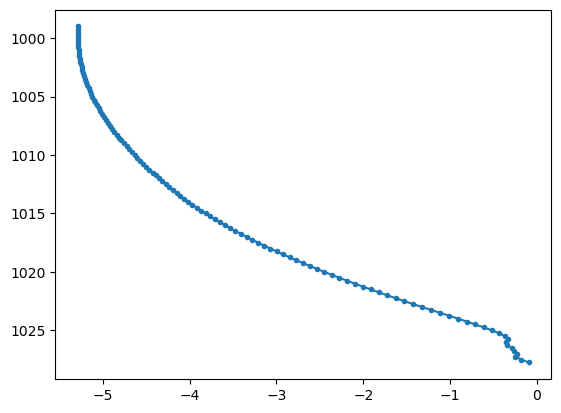

In [24]:
plt.plot(cs_mean_transport,edgeSigma_target,marker = '.')
plt.gca().invert_yaxis()

In [27]:
transport_transformed = grid.transform(ds_vIM.transportIntoMask, 'Z', edgeSigma_target, target_data = ds_vIM.edgeSigma)

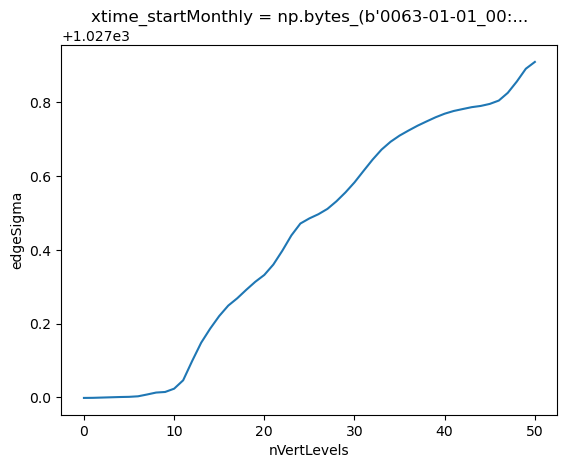

In [39]:
ds_vIM.edgeSigma.where(ds_vIM.edgeSigma >= 1014).isel(xtime_startMonthly=0, nEdges_sorted=44).plot()

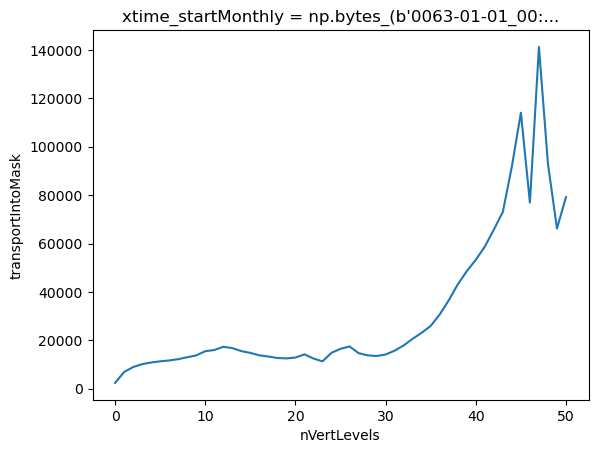

In [42]:
ds_vIM.transportIntoMask.where(ds_vIM.transportIntoMask!=0).isel(xtime_startMonthly=0, nEdges_sorted=44).plot()

(1026.0, 1028.0)

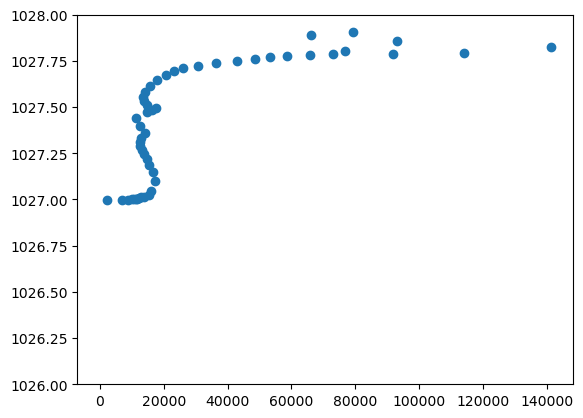

In [45]:
plt.scatter(
    ds_vIM.transportIntoMask.isel(xtime_startMonthly=0, nEdges_sorted=44),
    ds_vIM.edgeSigma.isel(xtime_startMonthly=0, nEdges_sorted=44)
)
plt.ylim(1026, 1028)

In [50]:
dso.dims

FrozenMappingWarningOnValuesAccess({'nMerHeatTransBinsP1': 181, 'nMocStreamfunctionBinsP1': 181, 'Time': 1, 'nCells': 236853, 'nVertLevels': 60, 'nEdges': 719506, 'nVertLevelsP1': 61, 'nRegions': 4, 'nOceanRegions': 7, 'nOceanRegionsTmp': 7})

In [53]:
grid = Grid(
    ds_vIM.expand_dims({'nVertLevelsP1': np.arange(0, 61, 1)}),
    coords = {'Z':{'center':'nVertLevels', 'outer':'nVertLevelsP1'}},
    periodic=False,
    autoparse_metadata=False
)


transport_transformed_cons = grid.transform(ds_vIM.transportIntoMask, 'Z', edgeSigma_target, target_data = ds_vIM.edgeSigma, method="conservative")

/global/homes/k/kuyeda/.conda/envs/lanl_env/lib/python3.13/site-packages/xgcm/transform.py:491: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(


(1026.0, 1028.0)

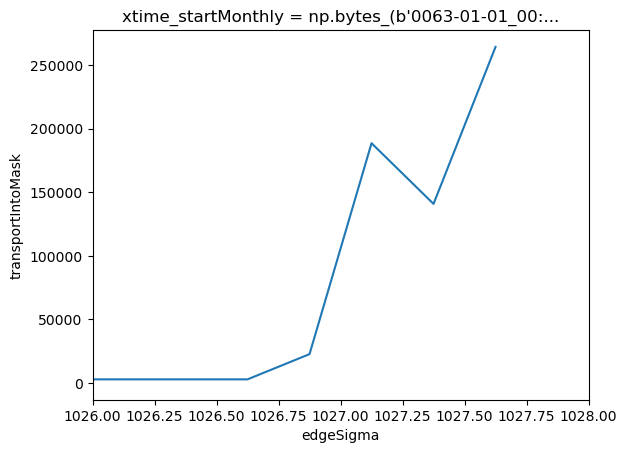

In [56]:
transport_transformed_cons.isel(xtime_startMonthly=0, nEdges_sorted=44).plot()
plt.xlim(1026, 1028)

In [ ]:
ds_vIM.edgeSigma.where(ds_vIM.edgeSigma >= 1014).isel(xtime_startMonthly=0, nEdges_sorted=44).plot()

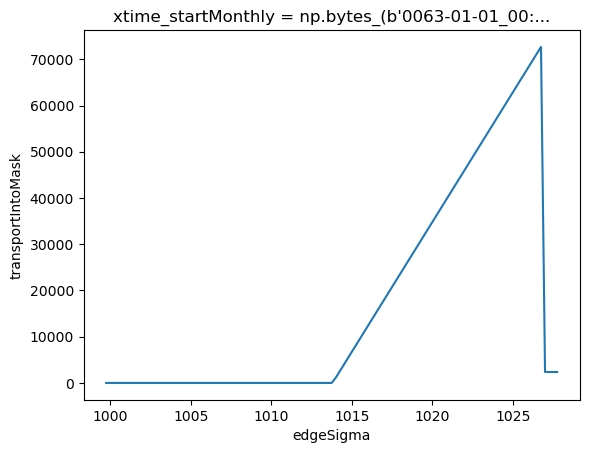

In [31]:
transport_transformed.isel(xtime_startMonthly=0, nEdges_sorted=44).plot()

/global/homes/k/kuyeda/.conda/envs/lanl_env/lib/python3.13/site-packages/numba/np/ufunc/gufunc.py:263: RuntimeWarning: divide by zero encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/global/homes/k/kuyeda/.conda/envs/lanl_env/lib/python3.13/site-packages/numba/np/ufunc/gufunc.py:263: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


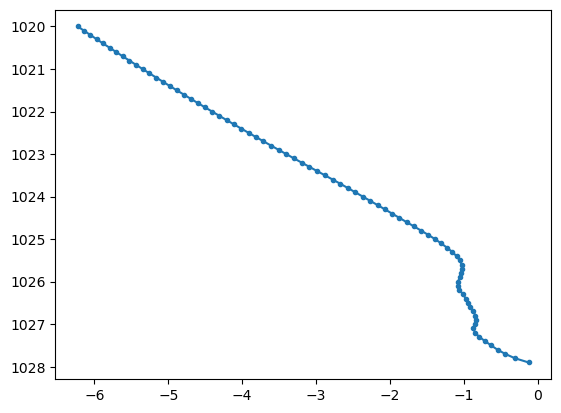

In [25]:
# create vertical xgcm grid
grid = Grid(ds_vIM, coords = {'Z':{'center':'nVertLevels'}},periodic=False,autoparse_metadata=False)

# define target values in density
# edgeSigma_target = np.linspace(1023,1028,100)
edgeSigma_target = np.arange(1020,1028,0.1)

# transform from nVertLevels to edgeSigma for the vertical coordinate
transport_transformed = grid.transform(ds_vIM.transportIntoMask, 'Z', edgeSigma_target, target_data = ds_vIM.edgeSigma)
mean_transport = transport_transformed.sum('nEdges_sorted').mean(dim='xtime_startMonthly') / 10**6
mean_transport_reversed  = mean_transport[::-1] # reverse order of transport into mask (surface transport now at bottom)
cs_mean_transport_reversed = np.cumsum(mean_transport_reversed) # take cumsum from 0 to 60 where 0 index is the bottom sigma transport into mask (bottom=0 cumsum)
cs_mean_transport = cs_mean_transport_reversed[::-1] # reverse the order again so now 0 index is the surface (+below) sigma transport into mask (surface=0 cumsum)

plt.plot(cs_mean_transport,edgeSigma_target,marker = '.')
plt.gca().invert_yaxis()

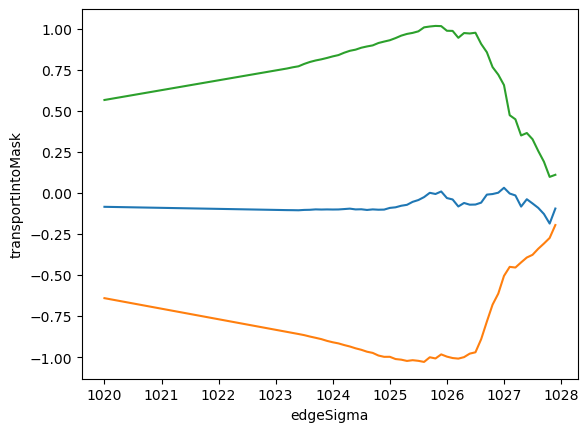

In [26]:
transport_neg = transport_transformed.where(transport_transformed < 0)
transport_pos = transport_transformed.where(transport_transformed > 0)

(transport_transformed.mean("xtime_startMonthly").sum("nEdges_sorted")*1e-6).plot()
(transport_neg.mean("xtime_startMonthly").sum("nEdges_sorted")*1e-6).plot()
(transport_pos.mean("xtime_startMonthly").sum("nEdges_sorted")*1e-6).plot()

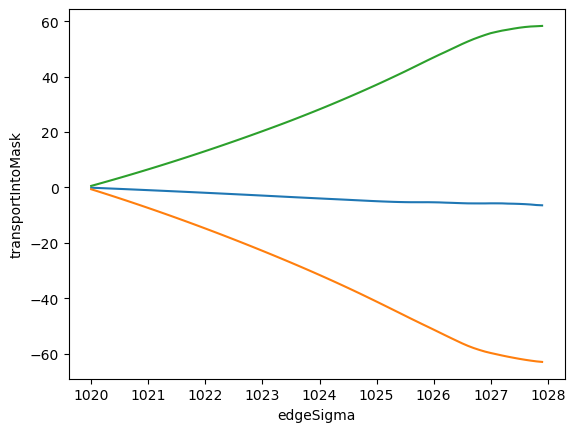

In [27]:
transport_neg = transport_transformed.where(transport_transformed < 0)
transport_pos = transport_transformed.where(transport_transformed > 0)

np.cumsum(transport_transformed.mean("xtime_startMonthly").sum("nEdges_sorted")*1e-6).plot()
np.cumsum(transport_neg.mean("xtime_startMonthly").sum("nEdges_sorted")*1e-6).plot()
np.cumsum(transport_pos.mean("xtime_startMonthly").sum("nEdges_sorted")*1e-6).plot()

In [28]:
transport_transformed.mean('xtime_startMonthly').sum() / 10**6

<xarray.DataArray 'transportIntoMask' ()> Size: 8B
array(-6.4306423)

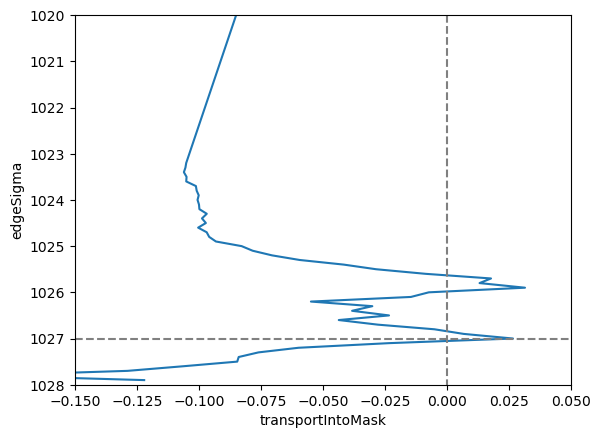

In [29]:
(transport_transformed.sum('nEdges_sorted').mean('xtime_startMonthly') / 10**6).plot(y='edgeSigma')
plt.ylim(1020,1028)
plt.xlim(-0.15,0.05)
plt.gca().invert_yaxis()
plt.vlines(0,ymin=1020, ymax=1028,color='gray',linestyle='--')
plt.hlines(1027, xmin=-0.15, xmax=0.15,color='gray',linestyle='--')

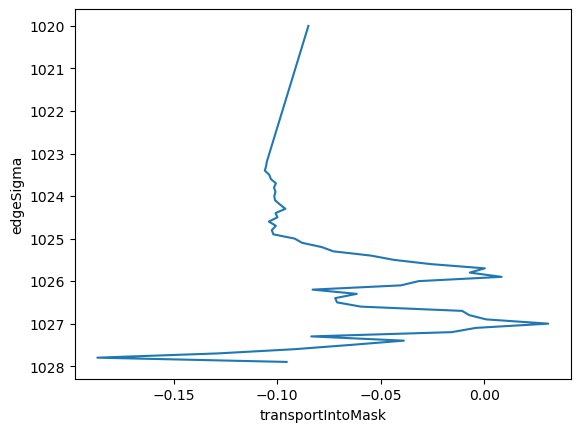

In [30]:
(transport_transformed.mean('xtime_startMonthly').sum('nEdges_sorted') / 10**6).plot(y='edgeSigma')
plt.gca().invert_yaxis()


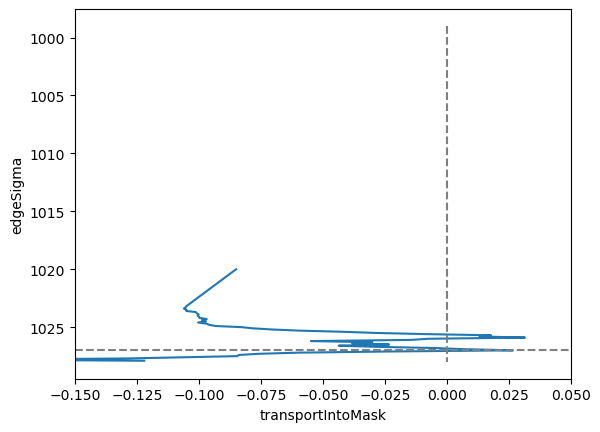

In [31]:
(transport_transformed.sum('nEdges_sorted').mean('xtime_startMonthly') / 10**6).plot(y='edgeSigma')
# plt.ylim(1020,1028)
plt.xlim(-0.15,0.05)
plt.gca().invert_yaxis()
plt.vlines(0,ymin=999, ymax=1028,color='gray',linestyle='--')
plt.hlines(1027, xmin=-0.15, xmax=0.15,color='gray',linestyle='--')

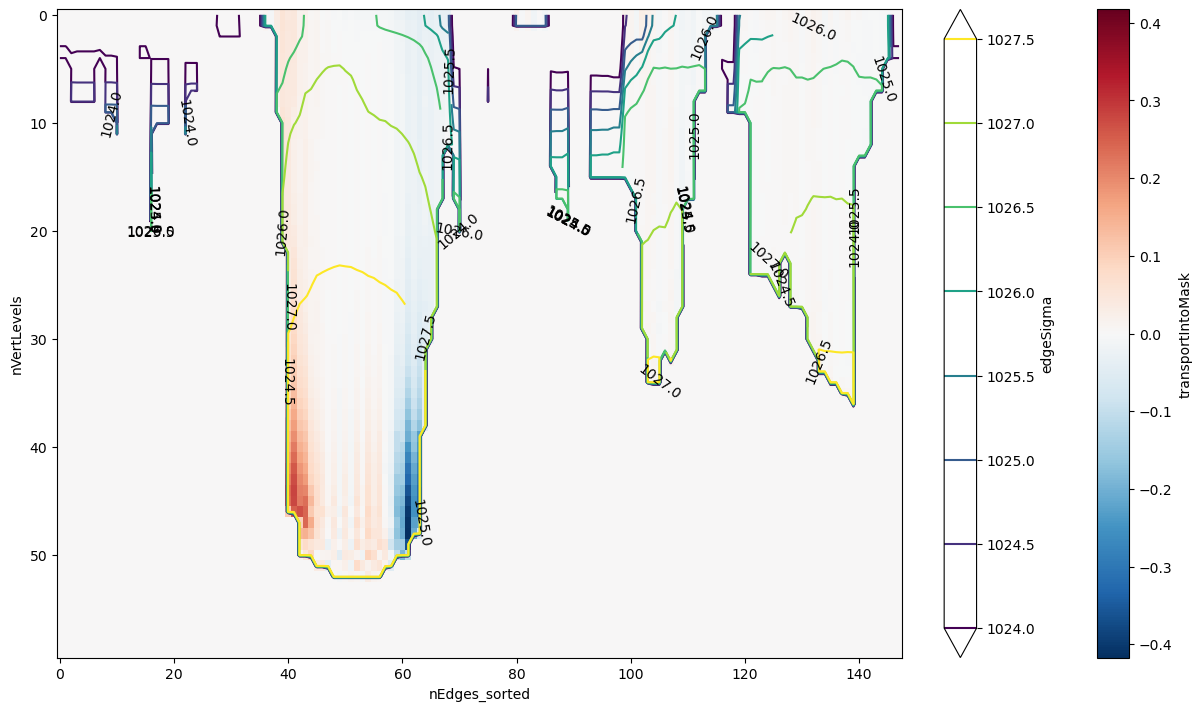

In [32]:
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True,figsize=(12,7))
(ds_vIM.mean(dim='xtime_startMonthly')/10**6).transportIntoMask.plot(y='nVertLevels')
clevels = np.arange(1024,1028,0.5)
for_clabel = ds_vIM.mean(dim='xtime_startMonthly').edgeSigma.plot.contour(y='nVertLevels',levels=clevels,add_colorbar=True)
ax.clabel(for_clabel,colors='k')
ax.invert_yaxis()

In [33]:
ds_vIM.mean(dim='xtime_startMonthly').edgeSigma


<xarray.DataArray 'edgeSigma' (nEdges_sorted: 148, nVertLevels: 60)> Size: 36kB
array([[1023.86505, 1023.8789 , 1023.93207, ...,  999.69525,  999.69525,
         999.69525],
       [1023.86505, 1023.8789 , 1023.93207, ...,  999.69525,  999.69525,
         999.69525],
       [1023.8196 , 1023.83405, 1023.89746, ...,  999.69525,  999.69525,
         999.69525],
       ...,
       [1026.1249 , 1026.1378 , 1026.2258 , ...,  999.69525,  999.69525,
         999.69525],
       [1023.86505, 1023.8789 , 1023.93207, ...,  999.69525,  999.69525,
         999.69525],
       [1023.86505, 1023.8789 , 1023.93207, ...,  999.69525,  999.69525,
         999.69525]], shape=(148, 60), dtype=float32)
Coordinates:
  * nEdges_sorted  (nEdges_sorted) int64 1kB 0 1 2 3 4 5 ... 143 144 145 146 147
    xr_Edges_id    (nEdges_sorted) int32 592B 17579 539876 ... 125371 17579
Dimensions without coordinates: nVertLevels

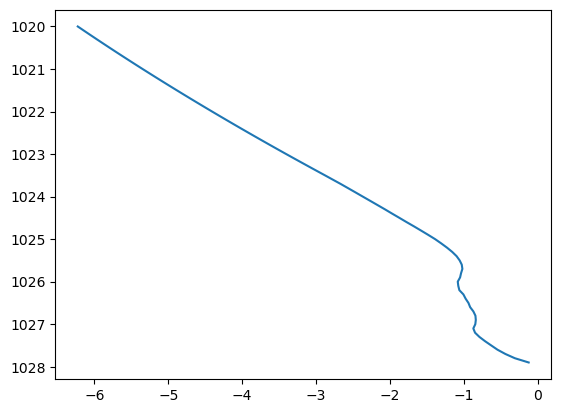

In [34]:
plt.plot(cs_mean_transport, edgeSigma_target)
plt.gca().invert_yaxis()

In [35]:
mean_transport_reversed  = mean_transport[::-1] # reverse order of transport into mask (surface transport now at bottom)
cs_mean_transport_reversed = np.cumsum(mean_transport_reversed) # take cumsum from 0 to 60 where 0 index is the bottom sigma transport into mask (bottom=0 cumsum)
cs_mean_transport = cs_mean_transport_reversed[::-1] # reverse the order again so now 0 index is the surface (+below) sigma transport into mask (surface=0 cumsum)
cs_mean_transport

<xarray.DataArray 'transportIntoMask' (edgeSigma: 80)> Size: 640B
array([-6.22595008, -6.14101149, -6.05544394, -5.96924744, -5.88242198,
       -5.79496758, -5.70688422, -5.6181719 , -5.52883064, -5.43886042,
       -5.34826125, -5.25703312, -5.16517604, -5.07269001, -4.97957503,
       -4.88583109, -4.7914582 , -4.69645636, -4.60082556, -4.50456581,
       -4.40767711, -4.31015946, -4.21201285, -4.11323729, -4.01383277,
       -3.9137993 , -3.81313688, -3.71184551, -3.60992518, -3.5073759 ,
       -3.40419767, -3.30039049, -3.19595435, -3.09088926, -2.98551199,
       -2.87950655, -2.77457565, -2.66952226, -2.56836125, -2.46751309,
       -2.36748915, -2.26698916, -2.16707562, -2.06732483, -1.97055136,
       -1.8718415 , -1.77470216, -1.6744465 , -1.57764099, -1.48183019,
       -1.38874801, -1.30601984, -1.22775119, -1.15727716, -1.0979676 ,
       -1.05640965, -1.02787546, -1.01940706, -1.03725261, -1.05046397,
       -1.08199658, -1.07475641, -1.06029766, -1.00552226, -0.97550036,
       -0.9373069 , -0.91401002, -0.87046226, -0.84270027, -0.83771733,
       -0.84454378, -0.87122659, -0.84796281, -0.78820392, -0.71228697,
       -0.62838732, -0.54389095, -0.43767006, -0.30894763, -0.12201275])
Coordinates:
  * edgeSigma  (edgeSigma) float64 640B 1.02e+03 1.02e+03 ... 1.028e+03

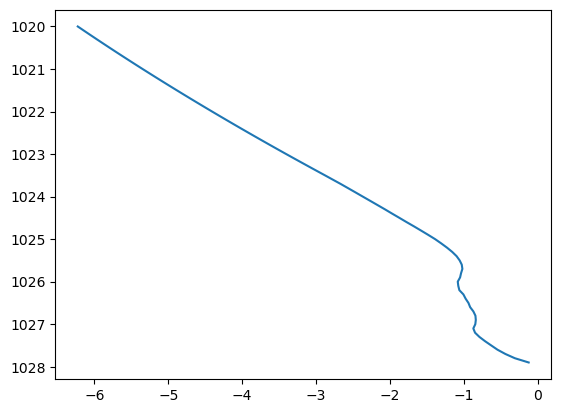

In [36]:
plt.plot(cs_mean_transport, edgeSigma_target)
plt.gca().invert_yaxis()

In [37]:
np.flipud(mean_transport.cumsum())

array([-6.22595008, -6.10393733, -5.91700245, -5.78828002, -5.68205913,
       -5.59756276, -5.51366311, -5.43774616, -5.37798727, -5.35472349,
       -5.3814063 , -5.38823275, -5.38324981, -5.35548782, -5.31194006,
       -5.28864318, -5.25044972, -5.22042782, -5.16565242, -5.15119367,
       -5.1439535 , -5.17548611, -5.18869747, -5.20654302, -5.19807462,
       -5.16954043, -5.12798248, -5.06867292, -4.99819889, -4.91993024,
       -4.83720207, -4.74411989, -4.64830909, -4.55150358, -4.45124792,
       -4.35410858, -4.25539872, -4.15862525, -4.05887446, -3.95896092,
       -3.85846093, -3.75843699, -3.65758883, -3.55642782, -3.45137443,
       -3.34644353, -3.24043809, -3.13506082, -3.02999573, -2.92555959,
       -2.82175241, -2.71857418, -2.6160249 , -2.51410457, -2.4128132 ,
       -2.31215078, -2.21211731, -2.11271279, -2.01393723, -1.91579062,
       -1.81827297, -1.72138427, -1.62512452, -1.52949372, -1.43449188,
       -1.34011899, -1.24637505, -1.15326007, -1.06077404, -0.96

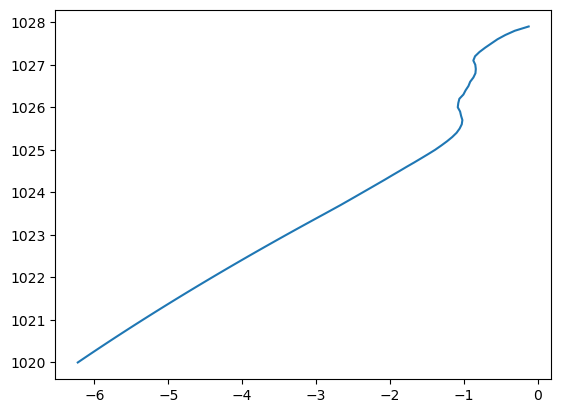

In [38]:
plt.plot(cs_mean_transport,edgeSigma_target)
# plt.gca().invert_yaxis()

In [39]:
# np.cumsum(transport.where(transport!=0).mean("xtime_startMonthly").sum("nEdges")*1e-6).plot()
# np.cumsum(transport_neg.where(transport_neg!=0).mean("xtime_startMonthly").sum("nEdges")*1e-6).plot()
# np.cumsum(transport_pos.where(transport_pos!=0).mean("xtime_startMonthly").sum("nEdges")*1e-6).plot()

In [40]:
# cellsOnTransectEdge_layerThickness.where(cellsOnTransectEdge_layerThickness!=0).isel(TWO=0).plot()

In [41]:
# cellsOnTransectEdge_layerThickness.where(cellsOnTransectEdge_layerThickness!=0).isel(TWO=1).plot()

In [42]:
# # create a new datavariable for transport, assign the transport to the corresponding edge
# dso['transportIntoMask'] = dso.veloIntoMask * 0 + np.nan

# for i in range(0,len(interp_transectEdgeLayerThickness)):
#     for j in range(0,len(dso.xtime_startMonthly)):
#         selectedEdge = transport.nEdges.isel(nEdges=i)
#         selectedMonth = dso.xtime_startMonthly[j]
    
#         dso.transportIntoMask.loc[dict(xtime_startMonthly=selectedMonth, nEdges = selectedEdge)] = transport.loc[dict(xtime_startMonthly = selectedMonth, nEdges = selectedEdge)]

# transportIntoMask_Sv = dso.transportIntoMask / 10**6

In [43]:
# # from the transect, create a mask to capture the entire region specified by the transects
# # this will also output lats and lons corresponding to test_verts
# filepath = './'
# filename = 'LS_test'
# geojson_file_name = 'Labrador Sea from transect algorithm'
# tags = "Labrador_Sea;Davis_Strait"
# author = "Kaila Uyeda"

# test_verts_lats, test_verts_lons, dsMasks = mps.transect_from_alg_create_nc(test_verts, 
#                                                                             mesh, 
#                                                                             filepath,
#                                                                             filename, 
#                                                                             geojson_file_name,
#                                                                             tags, 
#                                                                             author)

In [44]:
# net_transportIntoMask_Sv = transportIntoMask_Sv.sum(dim=['nEdges','nVertLevels'])
# net_transportIntoMask_Sv.mean(dim='xtime_startMonthly')

In [45]:
# transportIntoMask_Sv

In [46]:
# column_transport = dso.transportIntoMask.isel(xtime_startMonthly=0).sum(dim='nVertLevels')
# OSNAP_column_transport = column_transport.where(np.isin(mesh.nEdges, OSNAP_edges))
# OSNAP_column_transport_Sv = OSNAP_column_transport / 10**6

In [47]:
# non_OSNAP_column_transport = column_transport.where(~np.isin(mesh.nEdges, OSNAP_edges))
# non_OSNAP_column_transport = non_OSNAP_column_transport / 10**6

In [48]:
# PLOT JUST OSNAP
# fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True,figsize=(14,10))

# cellmask = dsMasks.regionCellMasks.isel(nRegions=0).astype(bool)
# b = mosaic.polypcolor(ax,descriptor,
#                   cellmask.astype(int),cmap='cool',alpha = 0.4,
#                   antialiaseds=False)


# c = mosaic.polypcolor(ax,descriptor,
#                   OSNAP_column_transport_Sv,cmap=cmo.balance,vmin=-10,vmax=10,
#                   antialiaseds=False)
# ax.set_xlim(290, 318)
# ax.set_ylim(51.5, 68)
# fig.colorbar(c, extend='both')
# ax.set_title('Net transport into mask through "OSNAP" array is ' + OSNAP_rounded_total_transport)
# # this is making me feel like I should flip the signs of the for loop?? 
# # But then this would mean there's a net increase of water in this region instead of export

In [49]:
# PLOT A SELECTED LEVEL
# fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True,figsize=(14,10))

# cellmask = dsMasks.regionCellMasks.isel(nRegions=0).astype(bool)
# b = mosaic.polypcolor(ax,descriptor,
#                   cellmask.astype(int),cmap='cool',alpha = 0.4,
#                   antialiaseds=False)


# c = mosaic.polypcolor(ax,descriptor,
#                   transportIntoMask_Sv.isel(Time=0,nVertLevels=20),cmap=cmo.balance,vmin=-0.05,vmax=0.05,
#                   antialiaseds=False)
# ax.set_xlim(290, 318)
# ax.set_ylim(51.5, 68)
# fig.colorbar(c, extend='both')
# # this is making me feel like I should flip the signs of the for loop?? 
# # But then this would mean there's a net increase of water in this region instead of export

In [50]:
# OSNAP_rounded_total_transport = str(np.round(OSNAP_column_transport_Sv.sum().values,decimals=3))
# str_net_transportIntoMask_Sv = str(np.round(net_transportIntoMask_Sv.values,decimals=3))
# str_nonOSNAP_transportIntoMask_Sv = str(np.round(non_OSNAP_column_transport.sum().values,decimals=3))

In [51]:

# fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True,figsize=(14,10))

# cellmask = dsMasks.regionCellMasks.isel(nRegions=0).astype(bool)
# b = mosaic.polypcolor(ax,descriptor,
#                   cellmask.astype(int),cmap='cool',alpha = 0.4,
#                   antialiaseds=False)

# c = mosaic.polypcolor(ax,descriptor,
#                   transportIntoMask_Sv.sum(dim='nVertLevels').mean(dim='xtime_startMonthly'),cmap=cmo.balance,vmin=-6,vmax=6,
#                   antialiaseds=False)


# ax.set_xlim(290, 318)
# ax.set_ylim(51.5, 68)
# fig.colorbar(c, extend='both')
# ax.set_title('Net transport into mask is ' + str_net_transportIntoMask_Sv + 'Sv \n OSNAP: ' + OSNAP_rounded_total_transport + ' & non-OSNAP: ' + str_nonOSNAP_transportIntoMask_Sv)
# # this is making me feel like I should flip the signs of the for loop?? 
# # But then this would mean there's a net increase of water in this region instead of export

```ruby
 'config_eos_linear_alpha': np.float64(0.2), 'config_eos_linear_beta': np.float64(0.8),
 'config_eos_linear_Tref': np.float64(5.0),
 'config_eos_linear_Sref': np.float64(35.0),
 'config_eos_linear_densityref': np.float64(1000.0),
 'config_eos_type': 'jm',
 ```
### [Fortran code for JM equation of state in MPAS-Ocean](https://github.com/kailauyeda/E3SM/blob/aab1d951cb7e6dcae737f8412109607efd25f2e3/components/mpas-ocean/src/shared/mpas_ocn_equation_of_state_jm.F#L17)
(unfortunately, I have no idea if there ie s a Python package that will calculate this...)

### to look at transport for a density bin that is greater than 1027.7 kg/m^3

In [52]:
# print('masked sigma max is 1027? That\'s it??')

In [53]:
# # we want to select only the potential density values greater than 1025
# # to do so, we need to interpolate potential density (on nCells) onto nEdges
# cellsOnTransectEdge_sigma = dso.timeMonthly_avg_potentialDensity.isel(nCells=xr_transect_cellsOnOceanEdges)

# # take the mean of the potential density along the dimension "TWO" (take the mean of sigma between TWO=0 cell and TWO=1 cell)
# interp_transectEdgeSigma = cellsOnTransectEdge_sigma.mean(dim='TWO')

# # reassign the interpolated sigma datavariable that now sit on the cell edge instead of cell center 
# # create a new datavariable for transport, assign the transport to the corresponding edge
# dso['edgeSigma'] = dso.transportIntoMask * 0 + np.nan

# dso.edgeSigma.loc[dict(xtime_startMonthly=dso.xtime_startMonthly, nEdges = interp_transectEdgeSigma.nEdges)] = interp_transectEdgeSigma.loc[dict(xtime_startMonthly=dso.xtime_startMonthly,nEdges = interp_transectEdgeSigma.nEdges)]
# # for i in range(0,len(interp_transectEdgeSigma)):
# #     selectedEdge = interp_transectEdgeSigma.nEdges.isel(nEdges=i)
    
# #     mesh.edgeSigma.loc[dict(Time=0, nEdges = selectedEdge)] = interp_transectEdgeSigma.loc[dict(nEdges = selectedEdge)]

# edgeSigma_mask = dso.edgeSigma#.isel(Time=0)

In [54]:
# edgeSigma_nadw = edgeSigma_mask > 1027.7
# np.count_nonzero(edgeSigma_nadw.astype(int)==1)

# nadw_transportMask_attempt = dso.transportIntoMask.where(edgeSigma_nadw ==True)

# full_column_transport = transportIntoMask_Sv.sum(dim='nVertLevels') 
# nadw_column_transport = nadw_transportMask_attempt.sum(dim='nVertLevels') / 10**6

In [55]:
# nadw_transportMask_attempt = dso.transportIntoMask.where(edgeSigma_nadw ==True)

In [56]:
# full_column_transport = transportIntoMask_Sv.sum(dim='nVertLevels') 
# nadw_column_transport = nadw_transportMask_attempt.sum(dim='nVertLevels') / 10**6

### to look at transport for all density bins

In [57]:
dso_mini = dso[['edgeSigma','transportIntoMask']].isel(nEdges = xr_transect_cellsOnOceanEdges.nEdges)

# create vertical xgcm grid
grid = Grid(dso, coords={'Z':{'center':'nVertLevels'}},periodic=False,autoparse_metadata=False)

# define target values in density
edgeSigma_target = np.linspace(999,1028,60)

# transform
transport_transformed = grid.transform(dso_mini.transportIntoMask, 'Z', edgeSigma_target, target_data = dso_mini.edgeSigma)
mean_transport = transport_transformed.sum('nEdges').mean(dim='xtime_startMonthly') / 10**6
cs_mean_transport = np.flipud(mean_transport.cumsum())
cs_mean_transport

KeyError: 'edgeSigma'

In [ ]:
plt.plot(cs_mean_transport,edgeSigma_target)
plt.gca().invert_yaxis()

In [ ]:
# multiindex to allow for binning transport by density
# .isel for nEdges that are along the tansect edge...
dso_mini = dso[['edgeSigma','transportIntoMask']].isel(nEdges = xr_transect_cellsOnOceanEdges.nEdges)
dso_mini

# create arrays from the values of coordinates in the mini dso
nEdge_array = dso_mini.nEdges.values
nVertLevels_array = dso_mini.nVertLevels.values
xtime_startMonthly_array = dso.xtime_startMonthly.values

# there's probably a more efficient, clear way to do this, but I cannot think of one rn
# swap dims for edges and vertices, but preserve the time dimension
# then re-concatenate the datasets so that there are edgesigma for every time step (month)
stacked_dso_mini = dso_mini.stack(edges_vertices = ('nEdges','nVertLevels'))
ds_swapped_dims_list = []
for i in range(0,len(stacked_dso_mini.xtime_startMonthly)):
    ds_byMonth = stacked_dso_mini.isel(xtime_startMonthly=i).swap_dims({'edges_vertices':'edgeSigma'})
    ds_byMonth_expand_dims = ds_byMonth.expand_dims(dim='xtime_startMonthly')
    ds_swapped_dims_list.append(ds_byMonth_expand_dims)

ds_swapped_dims = xr.concat(ds_swapped_dims_list,dim='edgeSigma')

# for each of the density bins, calculate the average 
# I'm going to try to bin first and then average those bins... 
# say there's a bunch of dense water transport in DJF (more than the yearly average)
# if we were to take a yearly average first, then we wouldn't see this transport at that density bin (it'd be accounted for at a lower transport 
# where the lower transport is due to an average transport that is lower than the dense water transport...

# to bin the data by density (edgeSigma), we will use xgcm
grid = Grid(dso, coords={'Z':{'center':'nVertLevels'}},periodic=False,autoparse_metadata=False)

# define the target values in edgeSigma
edgeSigma_target = np.linspace(999,1028,60)

# # transform
# nVertLevels_transformed = grid.transform(ds_swapped_dims.edgeSigma, 'Z', edgeSigma_target, target_data = ds_swapped_dims.transportIntoMask)
# nVertLevels_transformed

In [ ]:
dso

In [ ]:
ds_swapped_dims

In [ ]:
bin0 = list(binned_transport.groups.keys())[0]
print(binned_transport.apply(lambda x:x).sel(edgeSigma=bin0))

In [ ]:
# multiindex to allow for binning transport by density
# .isel for nEdges that are along the tansect edge...
mesh_mini = mesh[['edgeSigma','transportIntoMask']].isel(Time=0,nEdges = xr_transect_cellsOnOceanEdges.nEdges)

# create arrays from the values of coordinates in the mini mesh
nEdge_array = mesh_mini.nEdges.values
nVertLevels_array = mesh_mini.nVertLevels.values

stacked_mesh_mini = mesh_mini.stack(edges_vertices = ('nEdges','nVertLevels'))
# stacked_mesh_mini.edges_vertices

# collect the transports and sigmas
transport_nadw = stacked_mesh_mini.transportIntoMask
sigma_nadw = stacked_mesh_mini.edgeSigma
# nadw_edges_vertices = transport_nadw.edges_vertices

# convert to datasets
transport_nadw_ds = transport_nadw.to_dataset(name='transportIntoMask')
sigma_nadw_ds = sigma_nadw.to_dataset(name='edgeSigma')

# merge the edgeSigma and transportIntoMask datasets to become one single dataset 
# just in case a .where would take too long
stacked_mesh_mini = xr.merge([transport_nadw_ds, sigma_nadw_ds])

# convert edgeSigma into a coordinate
transport_from_edgeSigma = stacked_mesh_mini.swap_dims({"edges_vertices":"edgeSigma"})
transport_from_edgeSigma

# bin transportIntoMask by edgeSigma values
sigma_bins = np.linspace(1024.4,1028,30)
grouped_transport = transport_from_edgeSigma.transportIntoMask.groupby_bins(transport_from_edgeSigma.edgeSigma,bins=sigma_bins)

# get the sum of transport for each density bin
grouped_transport_sum = grouped_transport.sum() / 10**6

In [ ]:
# multiindex to allow for binning transport by density
# .isel for nEdges that are along the tansect edge...
mesh_mini = mesh[['edgeSigma','transportIntoMask']].isel(Time=0,nEdges = xr_transect_cellsOnOceanEdges.nEdges)

# create arrays from the values of coordinates in the mini mesh
nEdge_array = mesh_mini.nEdges.values
nVertLevels_array = mesh_mini.nVertLevels.values

stacked_mesh_mini = mesh_mini.stack(edges_vertices = ('nEdges','nVertLevels'))
# stacked_mesh_mini.edges_vertices

# collect the transports and sigmas
transport_nadw = stacked_mesh_mini.transportIntoMask
sigma_nadw = stacked_mesh_mini.edgeSigma
# nadw_edges_vertices = transport_nadw.edges_vertices

# convert to datasets
transport_nadw_ds = transport_nadw.to_dataset(name='transportIntoMask')
sigma_nadw_ds = sigma_nadw.to_dataset(name='edgeSigma')

# merge the edgeSigma and transportIntoMask datasets to become one single dataset 
# just in case a .where would take too long
stacked_mesh_mini = xr.merge([transport_nadw_ds, sigma_nadw_ds])

# convert edgeSigma into a coordinate
transport_from_edgeSigma = stacked_mesh_mini.swap_dims({"edges_vertices":"edgeSigma"})
transport_from_edgeSigma

# bin transportIntoMask by edgeSigma values
sigma_bins = np.linspace(1024.4,1028,30)
grouped_transport = transport_from_edgeSigma.transportIntoMask.groupby_bins(transport_from_edgeSigma.edgeSigma,bins=sigma_bins)

# get the sum of transport for each density bin
grouped_transport_sum = grouped_transport.sum() / 10**6

In [ ]:
transport_from_edgeSigma.edgeSigma.max()

In [ ]:
grouped_transport

In [ ]:
len(sigma_bins[1:])

In [ ]:
grouped_transport_sum = grouped_transport.sum() / 10**6
grouped_transport_cumsum_denseToLight = np.flipud(grouped_transport_sum.cumsum())
grouped_transport_cumsum_denseToLight

In [ ]:
grouped_transport_sum.cumsum()

In [ ]:
grouped_transport_cumsum_denseToLight

In [ ]:
grouped_transport_sum

In [ ]:
# plot this 
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True)
ax.plot(grouped_transport_cumsum_denseToLight, sigma_bins[1:])
ax.invert_yaxis()
ax.axvline(x=0,ls='--',color='gray')
ax.set_title('Transport of water into (+) and out of (-) masked LS region')
ax.set_ylabel('potential density')
ax.set_xlabel('Transport (Sv)')